In [1]:
#get the boys imported
import sys
sys.path.insert(0, "/home/ubuntu/data/code/Modules/")
import skimage
import numpy as np
import pickle
import gc
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.metrics import confusion_matrix
import cv2
import matplotlib.pyplot as plt
from keras import backend
from keras.models import Sequential
from keras.losses import binary_crossentropy
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, BatchNormalization, Flatten, Dropout
from keras.optimizers import SGD,Adadelta
import DataGenerator
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.model_selection import KFold
import random
import glob
import CNN_Module as cnn_module
import models
import DataGenerator_3d
import time

Using TensorFlow backend.


In [2]:
#this cell sets parametrs
result_acc = []
result_val_acc = []
start = time.time()
video_path = '/cropped_video100_140'
sample_gap = 10
depth = 10
sequence_length=10
epochs=25
stepsperepoch=100
k = 5
augment_train, augment_valid = cnn_module.get_augmentations_train_test()
params_train,params_test = cnn_module.get_params_train_test(140,100,augment_valid,augment_valid)    
params_train['dim']=(sequence_length,140,100)
params_test['dim']=(sequence_length,140,100)

In [3]:
#prep cells for feeding into CNN
control_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/trimdata/resistant/'))
sus_cells     = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/trimdata/susceptible/'))
print(len(control_cells))
print(len(sus_cells))

#label cells, and split cells into test and train, making sure to have equal proportion of sus and ctrl in both
control_cells_label = cnn_module.create_label_dict(control_cells,0)
sus_cells_label  = cnn_module.create_label_dict(sus_cells,1)

train_ctrl, test_ctrl = cnn_module.split_train_test(control_cells_label,0.8)
train_sus, test_sus = cnn_module.split_train_test(sus_cells_label,0.8)

train_labels = train_ctrl+train_sus
test_labels = test_ctrl+test_sus
all_labels = train_labels + test_labels
print(len(all_labels))

253
257
510


In [4]:
#this cell kfolds!
random.shuffle(train_labels)
kf = KFold(k)
kf.get_n_splits(train_labels)
#need to kfsplit along cells, to ensure that the valid and train data are properly separated
train_preds={}
kfold_val_acc = []
k_index = 0
t_start = time.time()
for train_index, test_index in kf.split(train_labels):
    kt_start = time.time()
    k_index +=1
    print('kfold', k_index)
    #find and get images for train cells
    cells_train = np.array(train_labels)[:,0][train_index]
    labels_train= np.array(train_labels)[:,1][train_index].astype('int')
    im_paths_train, im_labels_train = cnn_module.sample_label_images_in_cells_3d(cells_train,video_path,labels_train,sample_gap,depth)
    im_labels_train = dict(zip([i[0]for i in im_paths_train],im_labels_train))
    #find and get images for test cells
    cells_test = np.array(train_labels)[:,0][test_index]
    labels_test= np.array(train_labels)[:,1][test_index].astype(float).astype('int')
    im_paths_test, im_labels_test = cnn_module.sample_label_images_in_cells_3d(cells_test,video_path,labels_test,sample_gap,depth)
    im_labels_test = dict(zip([i[0]for i in  im_paths_test],im_labels_test))
    #set up generators
    training_generator = DataGenerator_3d.DataGenerator(im_paths_train, im_labels_train, **params_train,depth=depth)
    prediction_generator = DataGenerator_3d.DataGenerator(im_paths_test, im_labels_test, **params_test,depth=depth)
    validate_steps = len(im_paths_test)//32
    #fit the model!
    model = models.get_luke_3d_model2(input_shape=(140,100,1),sequence_length=sequence_length)
    fully_train_model = cnn_module.fit_model(model,training_generator,prediction_generator,epochs,stepsperepoch,validate_steps,params_train,params_test)
    val_acc = model.history.history['val_acc']

    #model_history = model.fit_generator(generator=training_generator,validation_data=prediction_generator,validation_steps=validate_steps,epochs = epochs,steps_per_epoch=stepsperepoch)
    #val_acc = model.history.history['val_acc']
    kfold_val_acc.append(val_acc)
    preds = model.predict_generator(generator=prediction_generator,workers=1, use_multiprocessing=False,steps = None)
    filenames_preds = dict(zip(prediction_generator.filenames,preds))
    train_preds.update(filenames_preds)
    kt_end = time.time()
    print('fold time =',kt_end-kt_start)
t_end = time.time()
print('total time =',t_end-t_start)

kfold 1




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/25





100/100 [==============================] - 64s 643ms/step - loss: 0.6896 - acc: 0.5797 - val_loss: 0.6862 - val_acc: 0.6214
Epoch 2/25
100/100 [==============================] - 55s 546ms/step - loss: 0.6771 - acc: 0.7231 - val_loss: 0.6673 - val_acc: 0.6070
Epoch 3/25
100/100 [==============================] - 55s 550ms/step - loss: 0.6564 - acc: 0.7644 - val_loss: 0.6552 - val_acc: 0.6904
Epoch 4/25
100/100 [==============================] - 55s 548ms/step - loss: 0.6206 - acc: 0.7697 - val_loss: 0.5996 - val_acc: 0.7493
Epoch 5/25
100/100 [==============================] - 55s 550ms/step - loss: 0.5727 - acc: 0.7850 - val_loss: 0.6313 - val_acc: 0.6717
Epoch 6/25
100/100 [==============================] - 55s 550ms/step - loss: 0.5243 - acc: 0.7

Epoch 17/25
100/100 [==============================] - 55s 549ms/step - loss: 0.1169 - acc: 0.9741 - val_loss: 0.5108 - val_acc: 0.8175
Epoch 18/25
100/100 [==============================] - 55s 550ms/step - loss: 0.0974 - acc: 0.9806 - val_loss: 0.5517 - val_acc: 0.8168
Epoch 19/25
100/100 [==============================] - 55s 550ms/step - loss: 0.0777 - acc: 0.9862 - val_loss: 0.6616 - val_acc: 0.7557
Epoch 20/25
100/100 [==============================] - 55s 550ms/step - loss: 0.0651 - acc: 0.9906 - val_loss: 0.4827 - val_acc: 0.8355
Epoch 21/25
100/100 [==============================] - 55s 550ms/step - loss: 0.0602 - acc: 0.9894 - val_loss: 0.6462 - val_acc: 0.7974
Epoch 22/25
100/100 [==============================] - 55s 550ms/step - loss: 0.0534 - acc: 0.9906 - val_loss: 0.4755 - val_acc: 0.8448
Epoch 23/25
100/100 [==============================] - 55s 550ms/step - loss: 0.0479 - acc: 0.9912 - val_loss: 0.6560 - val_acc: 0.7823
Epoch 24/25
100/100 [===========================

In [6]:
im_paths_train, im_labels_train, im_paths_test, im_labels_test = cnn_module.get_labels_images_3d(train_labels,test_labels,video_path,sample_gap,depth)
random.shuffle(im_paths_train)
random.shuffle(im_paths_test)

training_generator = DataGenerator_3d.DataGenerator(im_paths_train, im_labels_train, **params_train,depth=depth)
prediction_generator = DataGenerator_3d.DataGenerator(im_paths_test, im_labels_test, **params_test,depth=depth)

model = models.get_luke_3d_model2(input_shape=(140,100,1),sequence_length=sequence_length)
validate_steps = len(im_paths_test)//32
fully_train_model = cnn_module.fit_model(model,training_generator,prediction_generator,epochs,stepsperepoch,validate_steps,params_train,params_test)
test_preds = cnn_module.predict(test_labels,video_path,fully_train_model,sample_gap,params_test)

run_val_acc = model.history.history['val_acc']

Epoch 1/25
100/100 [==============================] - 69s 687ms/step - loss: 0.6880 - acc: 0.6022 - val_loss: 0.6788 - val_acc: 0.6543
Epoch 2/25
100/100 [==============================] - 57s 573ms/step - loss: 0.6762 - acc: 0.6988 - val_loss: 0.6546 - val_acc: 0.6971
Epoch 3/25
100/100 [==============================] - 57s 571ms/step - loss: 0.6548 - acc: 0.7250 - val_loss: 0.6214 - val_acc: 0.7331
Epoch 4/25
100/100 [==============================] - 57s 571ms/step - loss: 0.6194 - acc: 0.7491 - val_loss: 0.5910 - val_acc: 0.7416
Epoch 5/25
100/100 [==============================] - 57s 570ms/step - loss: 0.5830 - acc: 0.7562 - val_loss: 0.5540 - val_acc: 0.7461
Epoch 6/25
100/100 [==============================] - 57s 571ms/step - loss: 0.5456 - acc: 0.7778 - val_loss: 0.5348 - val_acc: 0.7562
Epoch 7/25
100/100 [==============================] - 57s 572ms/step - loss: 0.5029 - acc: 0.7969 - val_loss: 0.5439 - val_acc: 0.7376
Epoch 8/25
100/100 [==============================] - 5

In [7]:
print(len(kfold_val_acc))
print(len(train_preds))
print(len(run_val_acc))
print(len(test_preds))

result = [kfold_val_acc, train_preds, run_val_acc, test_preds]

5
9240
25
2472


In [8]:
pickle.dump(result,open('/home/ubuntu/data/code/3dCNN/3dchain_preds_final_trim.p','wb'))

In [ ]:
kfold_val_acc, all_preds = pickle.load(open('/home/ubuntu/data/code/3dCNN/3d_kfold_final_cipro.p','rb'))

[0.64529895 0.70566142 0.71472575 0.75009831 0.72229028 0.75676548
 0.7370614  0.75846693 0.74444949 0.76672716 0.76594323 0.75752924
 0.76416112 0.76057925 0.75835098 0.75939201 0.75545221 0.76119177
 0.76227818 0.7475247  0.76190512 0.77127193 0.76835804 0.75175943
 0.75043356] [0.072007   0.05473341 0.02592158 0.03943402 0.05353628 0.04686688
 0.05591686 0.04508025 0.03769756 0.04054482 0.04386825 0.03265874
 0.05909741 0.04091997 0.03872631 0.01360019 0.0480413  0.02879261
 0.02886727 0.04096864 0.0399158  0.03751129 0.03162364 0.02700795
 0.04299221]


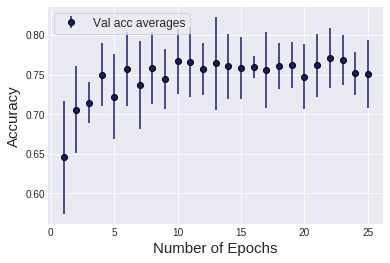

In [6]:
#plotting val acc averages with 
val_acc_avg = np.mean(kfold_val_acc, axis = 0)
val_acc_std = np.std(kfold_val_acc, axis = 0)
x_vals = np.arange(1,26)
print(val_acc_avg, val_acc_std)
plt.style.use('seaborn-darkgrid')
plt.errorbar(x_vals, val_acc_avg,val_acc_std, color='midnightblue', linewidth=2.5, elinewidth=1.5,fmt='o',mec='black', label = 'Val acc averages')
plt.legend(loc='upper left',frameon=True, fontsize=12)
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('Accuracy', size = 15)
#plt.xticks(np.arange(0, 25, 5))
#plt.ylim(0.4,1)

plt.show()